# **Import Models**

In [31]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import math
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree
import plotly.graph_objs as go
import plotly.offline as pyoff
import plotly.express as px
from scipy import stats
from sklearn import preprocessing


# **EDA**

In [32]:
alls = pd.read_csv('../1 Raw Data/all_credit_ledger_entries_with_customer_and_store.csv')
store = pd.read_csv('../1 Raw Data/Store-Category-Mapping_tobeshared.csv',encoding='cp1252')
cust = pd.read_csv('../1 Raw Data/customer-tier-details - tobeshared.csv')
cust.drop_duplicates(inplace = True)

In [33]:
cust.drop('new_customer_name (populate distinct names from any open dataset)',axis=1 , inplace=True)

In [34]:
#Where the state value is empty corresponding all columns are empty so i dropped na state
cust.dropna(subset=['state'], how='all', inplace=True)

In [35]:
# Fetching unique states from two dataset
al = alls.store_code.unique()
st = store.store_code.unique()
store_code_avl_in_st_notin_all = set(st) - set(al) #4
store_code_avl_in_all_notin_st = set(al) - set(st) #3

In [36]:
# Adding unique dataset to other dataset
for x in store_code_avl_in_st_notin_all:
    alls = alls.append({'store_code' : x} , ignore_index=True)
for x in store_code_avl_in_all_notin_st:
    store = store.append({'store_code' : x} , ignore_index=True)

In [37]:
alls

billing_timestamp transaction_type  amount  points  \
0       2019-03-19 16:18:00 +0530       adjustment     NaN  100.00   
1       2019-03-19 16:18:00 +0530       adjustment     NaN  100.00   
2       2019-03-19 16:18:00 +0530       adjustment     NaN  100.00   
3       2019-03-19 16:18:00 +0530       adjustment     NaN  100.00   
4       2019-03-19 16:18:01 +0530       adjustment     NaN  100.00   
...                           ...              ...     ...     ...   
358087  2019-08-26 00:00:00 +0530         purchase   578.0   11.56   
358088                        NaN              NaN     NaN     NaN   
358089                        NaN              NaN     NaN     NaN   
358090                        NaN              NaN     NaN     NaN   
358091                        NaN              NaN     NaN     NaN   

        store_code  customer_mobile  
0              NaN     2.578350e+11  
1              NaN     2.565790e+11  
2              NaN     2.436010e+11  
3              NaN     2.566190e+11  
4              NaN     2.566320e+11  
...            ...              ...  
358087    IMM00036     2.579030e+11  
358088    IMA00036              NaN  
358089     IMM9999              NaN  
358090    IMA00067              NaN  
358091  NA-IMA0131              NaN  

[358092 rows x 6 columns]

In [38]:
cust.rename(columns={"customer_id": "customer_mobile"})

customer_mobile                 created_at  gender        state  \
0         256605777046  2019-03-19 15:37:22 +0530    Male  Maharashtra   
1         240968898663  2019-03-19 15:37:22 +0530    Male  Maharashtra   
2         253538610862  2019-03-19 15:37:22 +0530    Male  Maharashtra   
3         243657073811  2019-03-19 15:37:22 +0530    Male  Maharashtra   
4         259232168932  2019-03-19 15:37:22 +0530    Male  Maharashtra   
...                ...                        ...     ...          ...   
43609     237338177781  2019-03-19 16:11:18 +0530  Female  Maharashtra   
43610     183465756782  2019-03-19 16:11:18 +0530  Female  Maharashtra   
43611     254958519792  2019-03-19 16:11:18 +0530  Female  Maharashtra   
43612     254957564035  2019-03-19 16:11:18 +0530  Female  Maharashtra   
43613     243562416370  2019-03-19 16:11:18 +0530    Male  Maharashtra   

              tier  
0      Blue Member  
1      Blue Member  
2      Blue Member  
3      Blue Member  
4      Blue Member  
...            ...  
43609  Blue Member  
43610  Blue Member  
43611  Blue Member  
43612  Blue Member  
43613  Blue Member  

[42834 rows x 5 columns]

In [39]:
# Merging
allcust = pd.merge(alls, cust, on='customer_mobile')
allmerge = pd.merge(allcust, store, on='store_code')

KeyError: 'customer_mobile'

In [40]:
# If a row which does not posses any value which was indicatied below will be dropeed
allmerge.dropna(subset=['amount','store_code','state','store_name','store_location','store_category','store_PriceCategory'],how='all',inplace=True)

NameError: name 'allmerge' is not defined

In [0]:
# Creating a dictionary to hold store_name and respective category
stname = allmerge.store_name.unique()
stcat = allmerge.store_category.unique()
str_name_cat = {}
for i in stname:
    if allmerge[allmerge['store_name']== i].store_category.count() > 1 :
        str_name_cat[i] = allmerge[allmerge['store_name'] == i].store_category.mode()[0]    

In [0]:
# This are some stores which was shown in the dataset only one time and the dont posess any Store_category
# So i took liberty to search approparity category for individual stores
str_name_cat['Khalifa Jewels'] = 'Jewellery'
str_name_cat['Chokers'] = 'Accessories,Jewellery'
str_name_cat['Floradelic'] = 'Gifts & Toys'
str_name_cat['Travel Fx'] = 'Travel'
str_name_cat['Peach Crush'] = 'Food & Beverage'
str_name_cat['The 4Th Quarter'] = 'Sports & Fitness'
str_name_cat['Tubs & Grubs'] = 'Food & Beverage'
str_name_cat['Hypercoaster'] = 'Entertainment & Leisure'
str_name_cat['Parampari Ethnics'] = "Women's Fashion,Men's Fashion"
str_name_cat['Books & Toys World'] = 'Books and Stationery,Gifts & Toys'
str_name_cat['Rollover'] = 'Food & Beverage'
str_name_cat['Panch Swaad'] = 'Food & Beverage'
str_name_cat['Treasure Trove'] = 'Jewellery'
str_name_cat['Jughead'] = 'Food & Beverage'
str_name_cat['Eastern Craft'] = 'Food & Beverage'
str_name_cat['Hypercoaster 12D'] = 'Entertainment & Leisure'
str_name_cat['One Small Peg'] = 'Food & Beverage'
str_name_cat['Young Lady'] = "Women's Fashion"
str_name_cat['Oceana Cafeteria'] = 'Food & Beverage'
str_name_cat['Dart Board'] = 'Entertainment & Leisure'
str_name_cat['Smoothy'] = 'Food & Beverage'
str_name_cat['Mumbai Waves'] = "Women's Fashion,Men's Fashion"
str_name_cat['Gizmo World'] = 'Electronics'
str_name_cat['CSK Café'] = 'Food & Beverage'
str_name_cat['Kaffir'] = 'Food & Beverage'
str_name_cat['Dessertz World'] = 'Food & Beverage'
str_name_cat['Travel Bags'] = 'Travel'
str_name_cat['Www'] = 'Entertainment & Leisure'
str_name_cat['Hotel Panch Swaad'] = 'Food & Beverage'
str_name_cat["Lorenzo'S Rosso Bambii"] = 'Food & Beverage'
str_name_cat['What?'] = "Women's Fashion,Men's Fashion"
str_name_cat['Stadium'] = "Accessories,Sports & Fitness,Women's Fashion,Men's Fashion"
str_name_cat['Classic Style'] = "Women's Fashion,Men's Fashion"
str_name_cat['Abstract Ties'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Hypercoaster Fec'] = "Entertainment & Leisure"
str_name_cat['Milano Jeans'] = "Women's Fashion,Men's Fashion"
str_name_cat['Cafe Platter'] = "Food & Beverage"
str_name_cat['Cafe Telaviv'] = "Food & Beverage"
str_name_cat['London Paris'] = "Women's Fashion,Men's Fashion"
str_name_cat['Timepieces'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Tnt Multiplex'] = "Entertainment & Leisure"
str_name_cat['Chic Bazaar'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Red Raincoat'] = "Women's Fashion"
str_name_cat['Python'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Mishti Mithai'] = "Food & Beverage"
str_name_cat["Susan'S Coffee"] = "Food & Beverage"
str_name_cat['Sabzi Mandi'] = "Grocery & Household"
str_name_cat['Doll House'] = "Gifts & Toys"
str_name_cat['Sicily'] = "Travel"
str_name_cat['Shinez'] = "Women's Fashion,Men's Fashion"
str_name_cat['Hotdogs '] = "Food & Beverage"
str_name_cat['Altitude'] = "Food & Beverage"
str_name_cat['Q Shoes'] = "Sports & Fitness"
str_name_cat['Julian Woods'] = "Sports & Fitness,Women's Fashion,Men's Fashion"
str_name_cat['Wizard'] = "Gifts & Toys"
str_name_cat['Bond Street Women'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Moi'] = "Travel"
str_name_cat['Gaming'] = "Entertainment & Leisure"
str_name_cat['Juhu Weddings'] = "Travel"
str_name_cat['Garnet '] = "Accessories,Jewellery"
str_name_cat['Kid Years'] = "Kids Fashion"
str_name_cat['Jumpin Beans'] = "Food & Beverage"
str_name_cat['Julietta'] = "Entertainment & Leisure"
str_name_cat['Genoa'] = "Travel"
str_name_cat['Style In India'] = "Women's Fashion,Men's Fashion"
str_name_cat['Horos'] = "Women's Fashion,Men's Fashion"
str_name_cat['Indian Earrings'] = "Accessories,Jewellery,Women's Fashion"
str_name_cat['5D Rider'] = "Entertainment & Leisure"
str_name_cat['Organic Skin Care'] = "Health & Wellness"
str_name_cat['Style Bedwear'] = "Accessories,Women's Fashion,Men's Fashion"
str_name_cat['Disco Fashion'] = "Women's Fashion,Men's Fashion"
str_name_cat['Default'] = "Women's Fashion,Men's Fashion"
str_name_cat['Little Giants'] = "Entertainment & Leisure"
str_name_cat['Sushmita Jewels'] = "Jewellery"
str_name_cat['Lollipops'] = "Food & Beverage"
str_name_cat['Diamond Parking'] = "Travel"
str_name_cat['The Dead Sea'] = "Travel"
str_name_cat['Beauty Palete'] = "Health & Wellness"
str_name_cat['Handcreams For You'] = "Food & Beverage"
str_name_cat['Melting Craft'] = "Jewellery"
str_name_cat['Parking'] = "Travel"
str_name_cat['Tiktok Watches'] = "Entertainment & Leisure"
str_name_cat['Anita Jaipur'] = "Women's Fashion,Men's Fashion"
str_name_cat['Log Land'] = "Travel"
str_name_cat['24 Carat'] = "Jewellery"
str_name_cat['Kayak'] = "Travel"
str_name_cat['Scream'] = "Food & Beverage"
str_name_cat['Luxeindulge'] = "Travel"
str_name_cat['Emerald Parking'] = "Travel"
str_name_cat['Take 5'] = "Food & Beverage"
str_name_cat["Nature'S Cosmetics"] = "Beauty & Grooming"
str_name_cat['Bellisima'] = "Accessories,Jewellery,Women's Fashion"
str_name_cat['Jaya Jewels'] = "Jewellery"
str_name_cat['Pilot'] = "Travel"
str_name_cat['Munch It Up'] = "Food & Beverage"
str_name_cat['Force '] = "Travel"
str_name_cat['7 Petals '] = "Travel"
str_name_cat['7D Rider'] = "Entertainment & Leisure"
str_name_cat['Hotdogs & Rolls'] = "Food & Beverage"
str_name_cat['Ballard Pier'] = "Travel"
str_name_cat['Pathfinder Test Store'] = "Books and Stationery,Gifts & Toys"
str_name_cat["Zoomin' Kids"] = "Kids Fashion,Accessories"

In [0]:
#Removing nan value from store_name
cleanedList = [x for x in stname if str(x) != 'nan']                                    

In [0]:
# Filled Store_category
for x in cleanedList:
    if df[df['store_name']== x].store_category.count() > 1 :
        temp = allmerge[allmerge['store_name'] == x]
        delval = allmerge[(allmerge['store_name'] == x)].index
        allmerge.drop(delval , inplace=True)
        temp.store_category.fillna(str_name_cat[x], inplace = True)
        allmerge = pd.concat([allmerge,temp], axis=0)

In [0]:
# Gender filling
# Based on Store Category and 
#  Based on average of gender in particular Store Category the gender is filled
gend = allmerge[allmerge['gender'].isna()]

allmerge = allmerge.dropna(subset=['gender'],how='all')

women = ["Accessories","Accessories,Gifts & Toys","Accessories,Jewellery","Accessories,Jewellery,Women's Fashion","Accessories,Men's Fashion","Accessories,Sports & Fitness,Women's Fashion,Men's Fashion","Accessories,Women's Fashion","Accessories,Women's Fashion,Men's Fashion","Beauty & Grooming","Electronics,Kids Fashion,Accessories,Grocery & Household,Home & Lifestyle,Women's Fashion,Men's Fashion,Books and Stationery,Gifts & Toys","Entertainment & Leisure","Food & Beverage","Food & Beverage,Grocery & Household","Gifts & Toys","Grocery & Household","Health & Wellness","Home & Lifestyle","Jewellery","Kids Fashion","Kids Fashion,Accessories","Kids Fashion,Accessories,Women's Fashion,Men's Fashion","Kids Fashion,Women's Fashion,Men's Fashion","Travel","Women's Fashion","Women's Fashion,Men's Fashion"]

men = ["Books and Stationery,Gifts & Toys","Electronics","Electronics,Entertainment & Leisure","Jewellery,Gifts & Toys","Men's Fashion","Sports & Fitness","Sports & Fitness,Women's","Fashion,Men's Fashion","Travel,Accessories,Sports & Fitness","Accessories,Men's Fashion","Sports & Fitness,Women's Fashion,Men's Fashion"]

for x in men:
    gend.loc[gend['store_category'] == x, ['gender']] = 'Male'

for x in women:
    gend.loc[gend['store_category'] == x, ['gender']] = 'Female'

df = pd.concat([allmerge,gend], axis=0)

In [0]:
# Even if some rows posess this three columns 'store_code','gender','store_name' na this rows will  be dropped
df.dropna(subset=['store_code','gender','store_name'],how='any',inplace=True)

# **Zip it**

In [0]:
dforg = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data_processed.csv')
dforg["date"]= pd.to_datetime(dforg["date"]) 
dforg["customer_mobile"] = dforg["customer_mobile"].astype(str)
dforg["amount"] = dforg["amount"].astype(int)

In [0]:
# I grouped all columns which were in less quantity 

# State
for i in dforg.state.unique():
    if dforg[dforg['state']== i ].state.count() < 100:
        dforg["state"].replace({i:"other"}, inplace=True)

# Store_category
for i in dforg.store_category.unique():
    if dforg[dforg['store_category']== i ].store_category.count() < 1000:
        dforg["store_category"].replace({i:"other_category"}, inplace=True)

# Store_name
for i in dforg.store_name.unique():
    if dforg[dforg['store_name'] == i].store_name.count() < 1300:
        dforg[dforg['store_name'] == i].store_name = 'Other_Store'

In [0]:
# Store sales avg high / low
for x in dforg.store_name.unique():
    meanval = math.ceil(dforg[dforg['store_name'] == x].amount.mean())
    indexs = dforg[dforg['store_name'] == x].index
    for i in indexs:
        tempdf = dforg[i:i+1].amount
        if meanval < int(tempdf):
            dforg[i:i+1].avg_amount = 1
        else:
            dforg[i:i+1].avg_amount = 0

# Scaled Amount
x =np.array(dforg['amount'])
x = x.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dforg['scaled_amount'] = x_scaled

# New Column For weekdays in text
dforg['week_words'] = dforg['date_week'].copy()
dforg['week_words'] = dforg['week_words'].apply(str)
wee = {'1':'Monday','2':'Tuesday','3':'Wednesday','4':'Thursday','5':'Friday','6':'Saturday','7':'Sunday'}
da = np.array(dforg.week_words)
for i in dforg.week_words.unique():
    da = [sub.replace(i, wee[i]) for sub in da] 
dforg['week_words'] = da

# Frequency Count of Purchase
dforg['purchase_freq'] = (dforg.groupby(['customer_mobile'])['customer_mobile'].transform('size'))

# Month
dforg['month'] = pd.DatetimeIndex(dforg['date']).month

# Month Words
dforg['month_words'] = dforg['month'].copy()
dforg['month_words'] = dforg['month_words'].apply(str)
mont = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June','7':'July','8':'August','9':'September','10':'October','11':'November','12':'December'}
da = np.array(dforg.month_words)
for i in dforg.month_words.unique():
    da = [sub.replace(i, mont[i]) for sub in da] 
dforg['month_words'] = da


In [0]:
dforg["customer_mobile"] = dforg["customer_mobile"].astype(str)
dforg["purchase_month_freq"] = 0

In [0]:
January =  pd.DataFrame(data = dforg[dforg.month_words == 'January'])
February =  pd.DataFrame(data = dforg[dforg.month_words == 'February'])
March =  pd.DataFrame(data = dforg[dforg.month_words == 'March'])
April =  pd.DataFrame(data = dforg[dforg.month_words == 'April'])
May =  pd.DataFrame(data = dforg[dforg.month_words == 'May'])
July =  pd.DataFrame(data = dforg[dforg.month_words == 'July'])
August =  pd.DataFrame(data = dforg[dforg.month_words == 'August'])
September =  pd.DataFrame(data = dforg[dforg.month_words == 'September'])
October =  pd.DataFrame(data = dforg[dforg.month_words == 'October'])
November =  pd.DataFrame(data = dforg[dforg.month_words == 'November'])
December =  pd.DataFrame(data = dforg[dforg.month_words == 'December'])
June =  pd.DataFrame(data = dforg[dforg.month_words == 'June'])

In [0]:
for j in df2.month_words.unique():
    for i in vars()[j].customer_mobile.unique():
        vars()[j]['purchase_month_freq'] = (vars()[j].groupby(['customer_mobile'])['customer_mobile'].transform('size'))

In [0]:
ddf = pd.concat([October, November, March, May, June, July, August,September, December, January, April, February])

In [0]:
ddf.to_csv('/content/drive/My Drive/Colab Notebooks/sat3.csv',index=False)

In [0]:
ddf.rename(columns={"avg_amount": "store_sales_position"})

# **Initiate**

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sat3.csv')
df["customer_mobile"] = df["customer_mobile"].astype(str)
df["amount"] = df["amount"].astype(int)
df["date"]= pd.to_datetime(df["date"]) 

dimall = df[df['store_location'] == 'Diamond Mall']
emmall = df[df['store_location'] == 'Emerald Mall']
dimall.drop(['store_location'],axis=1,inplace=True)
emmall.drop(['store_location'],axis=1,inplace=True)

# ***Mapping***

In [102]:
dfmap = df.copy()

import plotly.express as px
fig = px.box(dfmap,x='week_words', y='month')
fig.show()


# dfmap['year'] = [d.year for d in dfmap.date]
# years = dfmap['year'].unique()

# # Draw Plot
# fig, axes = plt.subplots(figsize=(20,7), dpi= 80)
# sns.boxplot(x='week_words', y='month', data=dfmap, ax=axes)
# # sns.boxplot(x='month', y='store_category', data=dfmap.loc[~dfmap.year.isin([2014, 2019]), :])

# # Set Title
# axes.set_title('Month-wise Box Plot\n(Week by Sales)', fontsize=18); 
# # axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
# plt.show()

In [106]:
dd = dimall[dimall['store_category'] == 'Food & Beverage']
import plotly.express as px
fig = px.box(dimall,x='week_words', y='month')
fig.show()


In [108]:
dd = dimall[dimall['store_name'] == 'Ajay Electronics']
import plotly.express as px
fig = px.box(dimall,x='week_words', y='month')
fig.show()

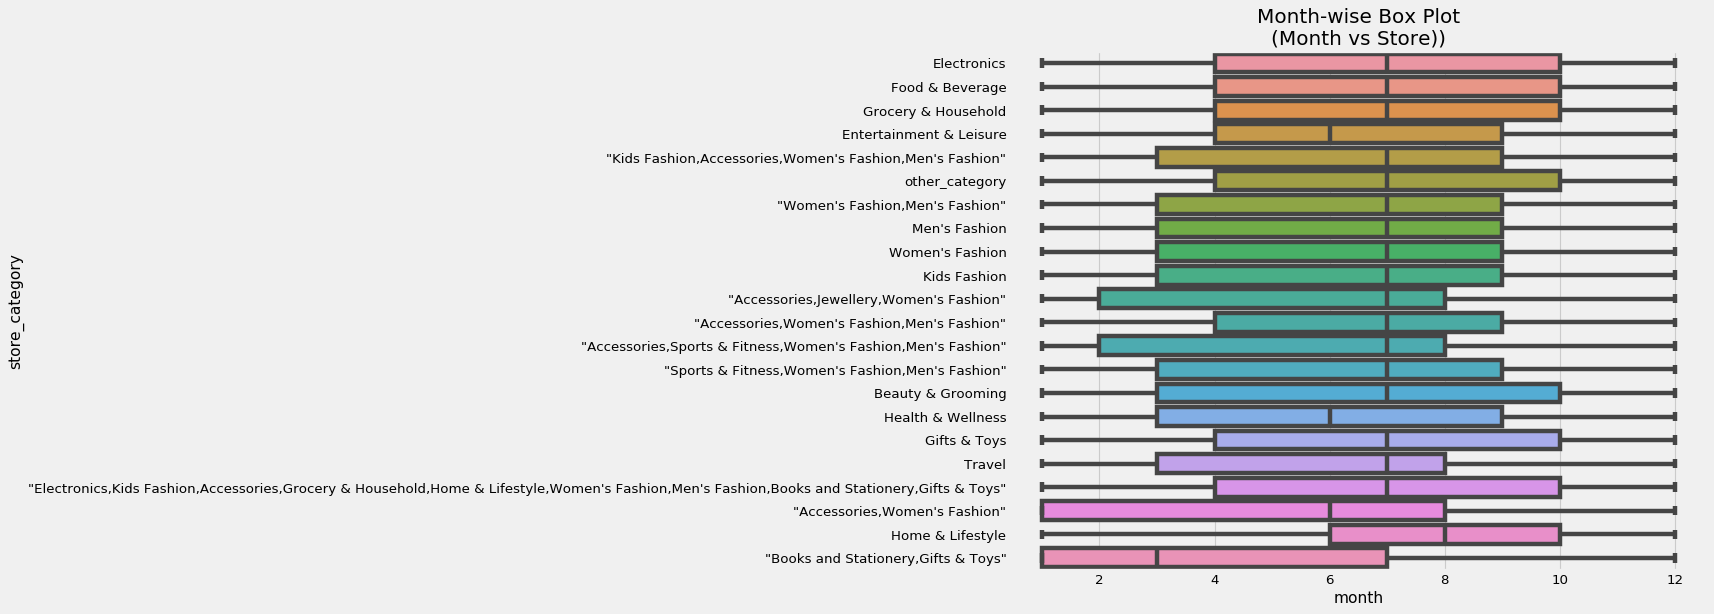

In [100]:
dfmap = df.copy()
# Prepare data
dfmap['year'] = [d.year for d in dfmap.date]
years = dfmap['year'].unique()

# Draw Plot
fig, axes = plt.subplots(figsize=(10,8), dpi= 80)
sns.boxplot(x='month', y='store_category', data=dfmap.loc[~dfmap.year.isin([2014, 2019]), :])

# Set Title
axes.set_title('Month-wise Box Plot\n(Month vs Store_Category))', fontsize=18)
plt.show()

# **Working Time Series**

In [0]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [0]:
# dimall.store_category.unique()

In [0]:
# ds = dimall[dimall['store_category']=='Grocery & Household']
ds = dimall[dimall['store_category']=='Food & Beverage']

ds = ds.sort_values(by='date')
dd =pd.DataFrame(data = ds[['date','amount']])


furniture = dd.iloc[:math.ceil(dd.shape[0]/4)*3, :]
df_test = dd.iloc[math.ceil(dd.shape[0]/4)*3:, :]


In [0]:
furniture = furniture.groupby('date')['amount'].sum().reset_index()

In [0]:
furniture = furniture.set_index('date')
# furniture.index

In [0]:
furniture.index = pd.to_datetime(furniture.index)
y = furniture['amount'].resample('MS').mean()


In [0]:
y.dropna(axis=0,inplace=True)

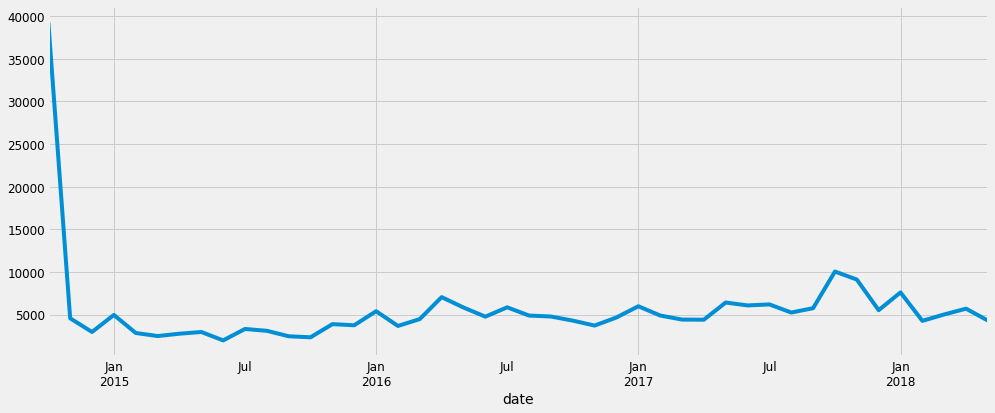

In [114]:
y.plot(figsize=(15, 6))
plt.show()

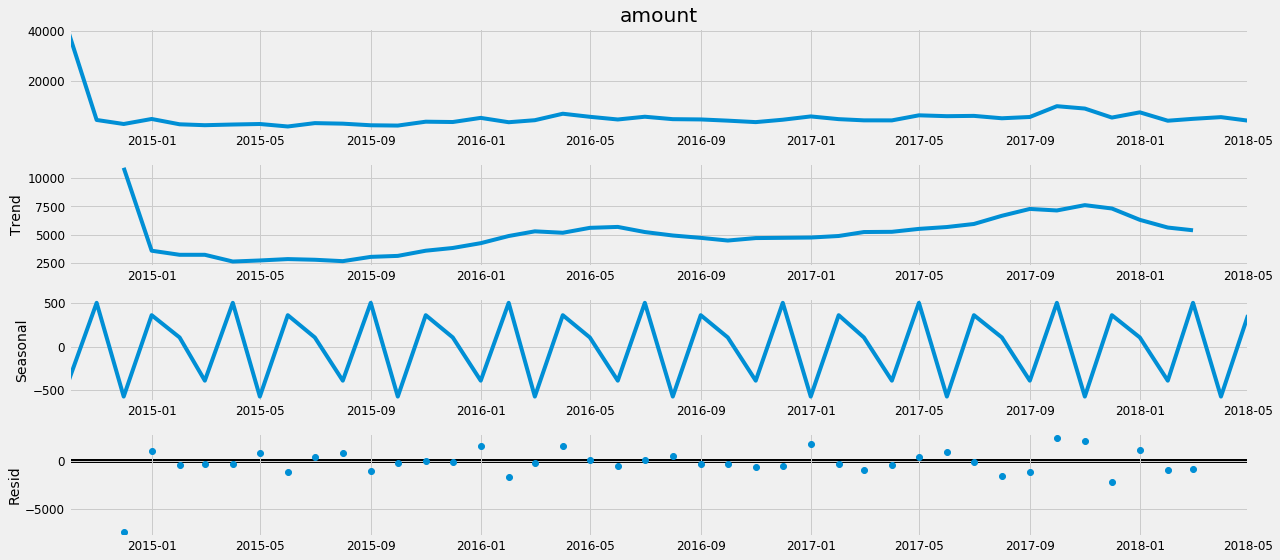

In [115]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq=5)
fig = decomposition.plot()
plt.show()

In [116]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [117]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:857.4820313014524
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1302.2630873875453
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:565.9976001113286
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:345.51006066235186
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:634.6694948893714
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1300.2508217762722
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:366.30420234079554
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:341.3113786830956
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:813.6579225680175
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3120.6399825066087
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:543.0955924167291
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:318.81766749389755
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:624.0651487442425
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2555.0084079187536
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:359.3328290910125
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:323.38853872788854
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:735.8219693678648
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1082.1240695324034
A

In [119]:

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1093      3.257     -0.034      0.973      -6.494       6.275
ma.L1         -0.0193      2.981     -0.006      0.995      -5.862       5.823
ar.S.L12      -1.0539      0.561     -1.880      0.060      -2.152       0.045
ma.S.L12      -0.1203      0.057     -2.101      0.036      -0.233      -0.008
sigma2      3.292e+06   2.26e-06   1.46e+12      0.000    3.29e+06    3.29e+06


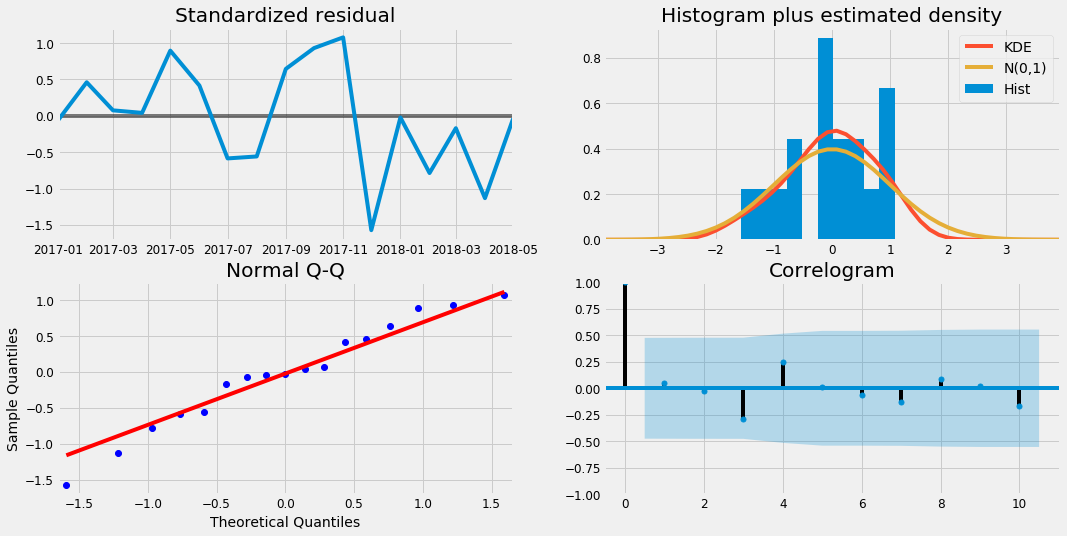

In [120]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

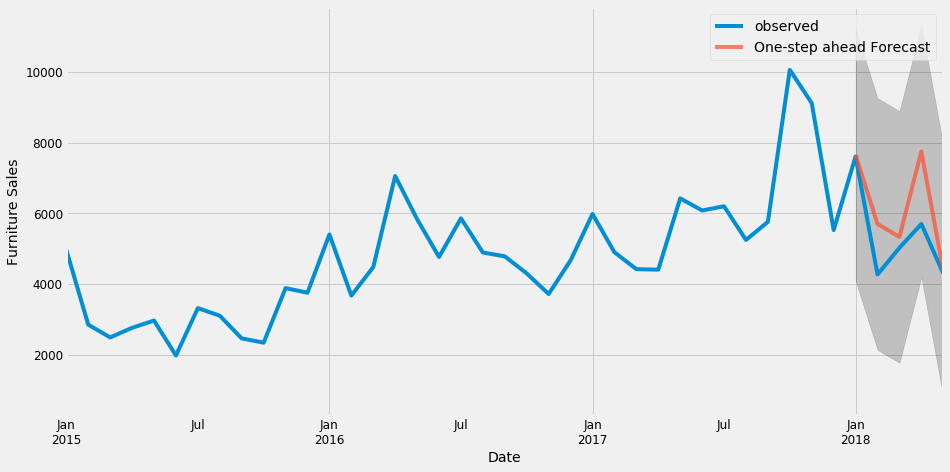

In [121]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [122]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1267687.2


In [123]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1125.92


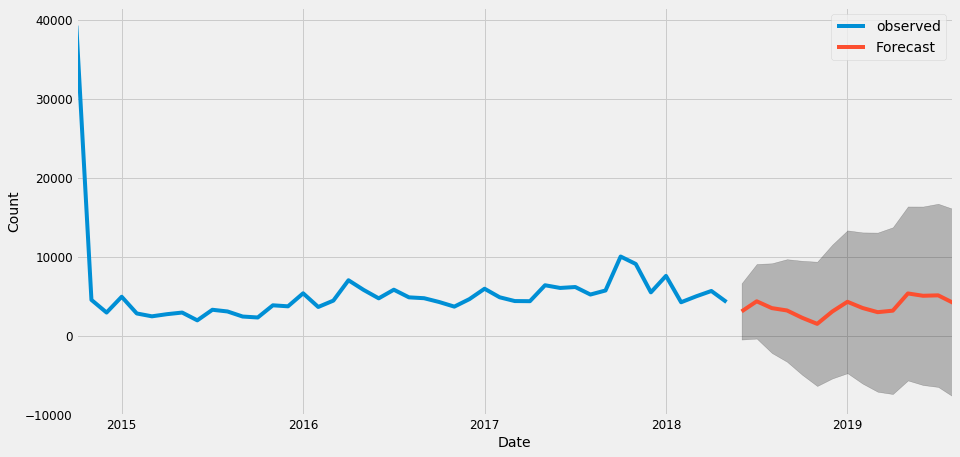

In [124]:
pred_uc = results.get_forecast(steps=15)
pred_ci = pred_uc.conf_int()



ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.legend()
plt.show()

# **Model Test**

In [0]:
dimall.store_name.unique()

In [0]:
ds = dimall[dimall['store_name']=='Ajay Electronics']
dflog = ds.select_dtypes('number')
dflog.drop(['amount','points','scaled_amount'],axis=1,inplace=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
 
x = dflog.drop('avg_amount', axis=1)
y = dflog['avg_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
 
predictions = logmodel.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       484
           1       0.00      0.00      0.00       237

    accuracy                           0.67       721
   macro avg       0.34      0.50      0.40       721
weighted avg       0.45      0.67      0.54       721

[[484   0]
 [237   0]]
0.6712898751733704


# ***Rough Work***

# **Time Series**

In [0]:
# ds = dimall[dimall['store_category']=='Food & Beverage']
# dflog = ds.select_dtypes('number')
# dflog.drop(['amount','points','scaled_amount'],axis=1,inplace=True)

In [0]:
ds = dimall[dimall['store_category']=='Travel']
ds = ds.sort_values(by='date')
dd =pd.DataFrame(data = ds[['date','amount']])

df_diff = dd.iloc[:math.ceil(dd.shape[0]/4)*3, :]
df_test = dd.iloc[math.ceil(dd.shape[0]/4)*3:, :]

In [99]:
plot_data = [
    go.Scatter(
        x=df_diff['date'],
        y=df_diff['amount'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [0]:
df_diff['prev_sales'] = df_diff['amount'].shift(1)
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['amount'] - df_diff['prev_sales'])

In [101]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised

date  amount    diff    lag_1  ...   lag_9  lag_10  lag_11  lag_12
0    2014-12-23    1395  -295.0 -23290.0  ...  -430.0  -750.0  -270.0  2635.0
1    2015-01-19    2195   800.0   -295.0  ...  8140.0  -430.0  -750.0  -270.0
2    2015-01-19    2970   775.0    800.0  ...  -100.0  8140.0  -430.0  -750.0
3    2015-01-22    3587   617.0    775.0  ... -8265.0  -100.0  8140.0  -430.0
4    2015-02-01    4760  1173.0    617.0  ...   190.0 -8265.0  -100.0  8140.0
..          ...     ...     ...      ...  ...     ...     ...     ...     ...
144  2019-04-20     999 -2688.0      0.0  ... -1685.0 -7366.0  7510.0 -1610.0
145  2019-04-20      60  -939.0  -2688.0  ...  -409.0 -1685.0 -7366.0  7510.0
146  2019-04-20      50   -10.0   -939.0  ...     0.0  -409.0 -1685.0 -7366.0
147  2019-04-20      50     0.0    -10.0  ...   445.0     0.0  -409.0 -1685.0
148  2019-04-21     999   949.0      0.0  ...  -286.0   445.0     0.0  -409.0

[149 rows x 15 columns]

In [102]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.3971491830171465


In [0]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['diff','date'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

In [0]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [0]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

In [0]:
y_pred = model.predict(X_test,batch_size=1)

In [0]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [0]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_diff[-7:].date)
act_sales = list(df_diff[-7:].amount)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

In [119]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_diff,df_result,on='date',how='left')
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['amount'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# **Model Creation 1**

In [0]:
ds = dimall[dimall['store_category']=='Food & Beverage']
dflog = ds.select_dtypes('number')
dflog.drop(['amount','points','scaled_amount'],axis=1,inplace=True)

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
 
x = dflog.drop('avg_amount', axis=1)
y = dflog['avg_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
 
predictions = logmodel.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      5643
           1       0.00      0.00      0.00      2504

    accuracy                           0.69      8147
   macro avg       0.35      0.50      0.41      8147
weighted avg       0.48      0.69      0.57      8147

[[5643    0]
 [2504    0]]
0.6926476003436848


In [0]:
plt.figure(figsize=(16,10))
sns.heatmap(dflog[dflog.columns].corr(),annot=True)

# Model 3

NO: ROC AUC=0.500
YES: ROC AUC=0.546


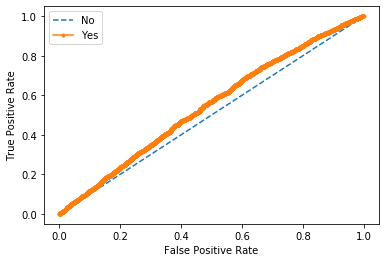

In [90]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(dflog.drop('avg_amount',axis=1),dflog['avg_amount'], test_size=0.30,random_state=111)

ns_probs = [0 for _ in range(len(testy))]

model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

lr_probs = model.predict_proba(testX)

lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

print('NO: ROC AUC=%.3f' % (ns_auc))
print('YES: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Yes')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.000 auc=0.327


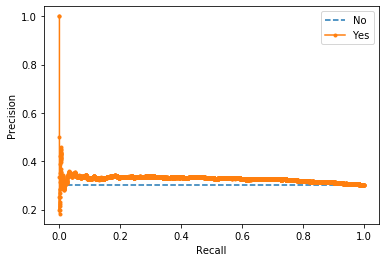

In [91]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(dflog.drop('avg_amount',axis=1),dflog['avg_amount'], test_size=0.30,random_state=111)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = model.predict(testX)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Yes')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# **Dedaction**

In [3]:
from scipy import stats
z = np.abs(stats.zscore(df.select_dtypes('number')))
print(z)

[[2.36786646 1.34711493 3.12730831 ... 0.76613655 1.012491   0.7942449 ]
 [2.36786646 1.34711493 1.39884394 ... 0.28662124 1.012491   2.31030031]
 [2.36786646 1.34711493 0.24324365 ... 0.28662124 1.012491   2.31030031]
 ...
 [0.24124958 0.0330223  0.23870162 ... 3.26943497 1.25729989 2.48520426]
 [0.24528846 1.34711493 0.25810418 ... 0.17615354 1.25729989 0.400711  ]
 [0.24528846 1.34711493 1.10441986 ... 0.37135238 1.25729989 0.68492993]]


In [0]:
threshold = 3
Q1 = df.select_dtypes('number').quantile(0.25)
Q3 = df.select_dtypes('number').quantile(0.75)
IQR = Q3 - Q1

In [0]:
df3 = df.select_dtypes('number')[(z<3).all(axis=1)]

In [0]:
df3 = df3[~((df3<(Q1 - 1.5 * IQR))| (df3>(Q3 + 1.5 * IQR))).any(axis=1)]

In [7]:
df3

date_freq  date_week  amount  ...  purchase_freq  month  purchase_month_freq
15              2          2     270  ...             15     10                    5
16              2          2    4099  ...             15     10                    5
44              2          6     299  ...            673     10                   50
51              2          5    3999  ...             20     10                    4
58              1          4    1990  ...            234     10                   28
...           ...        ...     ...  ...            ...    ...                  ...
331864          2          7     169  ...            386      2                   28
331866          1          4    5592  ...              7      2                    1
331868          3          5    2053  ...             50      2                    4
331869          3          5    2490  ...             50      2                    4
331871          1          1     150  ...            270      2                   19

[228951 rows x 9 columns]

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
 
x = df3.drop('amount', axis=1)
y = df3['amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)
 
predictions = logmodel.predict(x_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(accuracy_score(y_test, predictions))

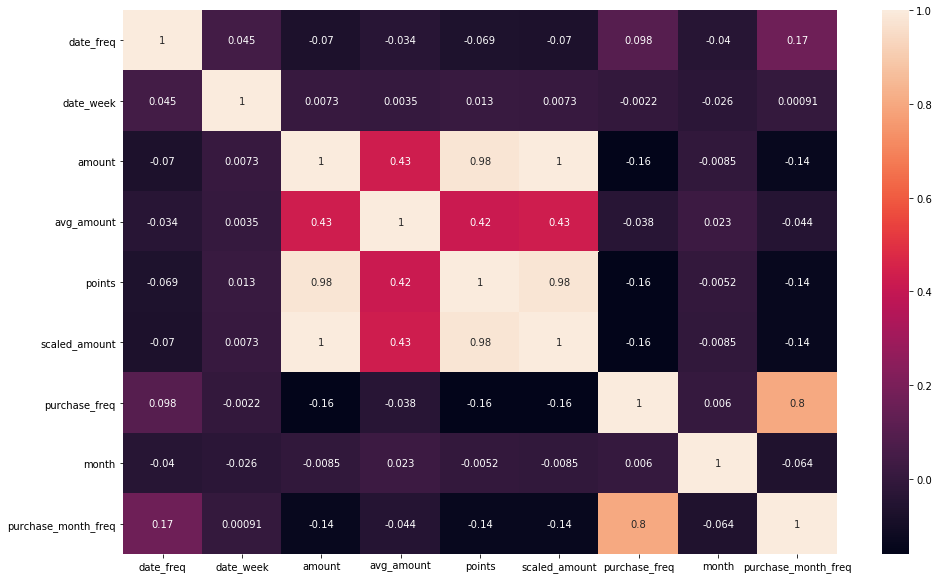

In [13]:
plt.figure(figsize=(16,10))
sns.heatmap(df3[df3.columns].corr(),annot=True)